https://colab.research.google.com/drive/1Xed5YSpLsLfkn66OhhyNzr05VE89enng#scrollTo=Hh0YZh1QMTh7

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

import numpy as np

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

torch.manual_seed(446)
np.random.seed(446)

# basic

In [3]:
a = [1,2,3]
a_np = np.array(a)
a_torch = torch.tensor(a)
a, a_np, a_torch

([1, 2, 3], array([1, 2, 3]), tensor([1, 2, 3]))

In [4]:
torch.from_numpy(a_np)

tensor([1, 2, 3])

In [5]:
a_torch.numpy()

array([1, 2, 3])

In [6]:
a = torch.tensor([1.0, 2.0])
b = torch.tensor([3.0, 4.0])
a + b

tensor([4., 6.])

In [7]:
torch.norm(b)

tensor(5.)

In [8]:
a = torch.tensor(
    [[1.0, 2.0],
     [3.0, 4.0],
     [5.0, 6.0],]
)

torch.mean(a, dim=0), torch.mean(a, dim=1)

(tensor([3., 4.]), tensor([1.5000, 3.5000, 5.5000]))

In [9]:
a = torch.arange(8)
a_ = a.view(4, 2)
a, a_, a_.size()

(tensor([0, 1, 2, 3, 4, 5, 6, 7]),
 tensor([[0, 1],
         [2, 3],
         [4, 5],
         [6, 7]]),
 torch.Size([4, 2]))

In [10]:
x=torch.tensor([[1,2],
                [3,4],
                [5,6]])

y=torch.tensor([7,8])

z=x+y

x.size(), y.size(), z.size()

(torch.Size([3, 2]), torch.Size([2]), torch.Size([3, 2]))

In [11]:
# e = (a+b) * (b+1)
a = torch.tensor(2., requires_grad=True)
b = torch.tensor(1., requires_grad=True)

c = a + b
d = b + 1

e = c * d

c, d, e

(tensor(3., grad_fn=<AddBackward0>),
 tensor(2., grad_fn=<AddBackward0>),
 tensor(6., grad_fn=<MulBackward0>))

In [12]:
cpu = torch.device('cpu')
gpu = torch.device('cuda') # not gpu

cpu, gpu

(device(type='cpu'), device(type='cuda'))

In [13]:
x = torch.tensor([1., 2., 3.])
x_ = x.to(cpu)
x_

tensor([1., 2., 3.])

In [14]:
x = torch.tensor([1., 2., 3.])
x_ = x.to(gpu)
x_

tensor([1., 2., 3.], device='cuda:0')

In [24]:
def f(x):
    return (x-2)**3

def grad_f(x):
    return 3*(x-2)**2

x = torch.tensor([1.0], requires_grad=True)

y = f(x)
y.backward()

grad_f(x), x.grad

(tensor([3.], grad_fn=<MulBackward0>), tensor([3.]))

In [32]:
def g(w):
    w0 = w[0]
    w1 = w[1]
    z = 2*w0*w1 + w1*torch.cos(w0)
    return z

def grad_g(w):
    w0 = w[0]
    w1 = w[1]
    grad_0_g = 2*w1 - w1*torch.sin(w0)
    grad_1_g = 2*w0 + torch.cos(w0)
    arr = [grad_0_g, grad_1_g]
    return torch.tensor(arr)

w = torch.tensor([np.pi, 1], requires_grad=True)

z = g(w)
z.backward()

w.grad, grad_g(w)

(tensor([2.0000, 5.2832]), tensor([2.0000, 5.2832]))

In [75]:
def f(x):
    return (x-2)**2

def grad_f(x):
    return 2*(x-2)

x = torch.tensor([5.0], requires_grad=True)
step_size = 0.25

for i in range(5):
    y = f(x)
    y.backward()
    
    print(
        'epoch = %d,'%(i),
        'x.grad = %.5f,'%(x.grad.item()),
        'grad_f(x) = %.5f,'%(grad_f(x).item()),
        'x = %.5f,'%(x.item()),
        'f(x) = %.5f,'%(f(x).item()),
    )
    
    x.data = x.data - step_size*x.grad
    
    
    x.grad.detach_()
    x.grad.zero_()
    

epoch = 0, x.grad = 6.00000, grad_f(x) = 6.00000, x = 5.00000, f(x) = 9.00000,
epoch = 1, x.grad = 3.00000, grad_f(x) = 3.00000, x = 3.50000, f(x) = 2.25000,
epoch = 2, x.grad = 1.50000, grad_f(x) = 1.50000, x = 2.75000, f(x) = 0.56250,
epoch = 3, x.grad = 0.75000, grad_f(x) = 0.75000, x = 2.37500, f(x) = 0.14062,
epoch = 4, x.grad = 0.37500, grad_f(x) = 0.37500, x = 2.18750, f(x) = 0.03516,


# linear regression

## handcrafted

In [128]:
def model(X, w):
    return X @ w

# the residual sum of squares loss function
def rss(y, y_hat):
    return torch.norm(y - y_hat)**2 / n # [delta_1, delta_2] => sqrt(delta_1**2 + delta_2**2) => (delta_1**2 + delta_2**2)

# analytical expression for the gradient
def grad_rss(X, y, w):
    return -2*X.t() @ (y - X @ w) / n

dim = 2
n = 50
X = torch.randn(n, dim)
true_w = torch.tensor([[-1.0], [2.0]]) # shape=2x1
y = X @ true_w + torch.randn(n,1) * 0.01

# print(X)
# print(true_w)
# print(y)

print('###########################################################################')
step_size = 0.1
w = torch.tensor([[1.], [0.]], requires_grad=True)
# w = torch.tensor([1., 0.], requires_grad=True).view(2,1)

for i in range(20):
    y_hat = model(X, w)
    loss = rss(y, y_hat)
    loss.backward()
    
    print(
        'epoch = %d,'%(i),
        'loss = %.3f,'%(loss.data),
        'w = %s,'%(w.data.view(-1)),
    )
    
    w.data = w.data - step_size * w.grad
    
    w.grad.detach()
    w.grad.zero_()

print('###########################################################################')
print('w \t= %s,'%(w.data.view(-1)))
print('true_w \t= %s,'%(true_w.data.view(-1)))


###########################################################################
epoch = 0, loss = 9.653, w = tensor([1., 0.]),
epoch = 1, loss = 5.519, w = tensor([0.5712, 0.5367]),
epoch = 2, loss = 3.174, w = tensor([0.2315, 0.9265]),
epoch = 3, loss = 1.834, w = tensor([-0.0366,  1.2104]),
epoch = 4, loss = 1.065, w = tensor([-0.2477,  1.4176]),
epoch = 5, loss = 0.620, w = tensor([-0.4135,  1.5693]),
epoch = 6, loss = 0.362, w = tensor([-0.5433,  1.6806]),
epoch = 7, loss = 0.212, w = tensor([-0.6448,  1.7626]),
epoch = 8, loss = 0.125, w = tensor([-0.7241,  1.8230]),
epoch = 9, loss = 0.073, w = tensor([-0.7858,  1.8678]),
epoch = 10, loss = 0.043, w = tensor([-0.8339,  1.9009]),
epoch = 11, loss = 0.026, w = tensor([-0.8713,  1.9256]),
epoch = 12, loss = 0.015, w = tensor([-0.9003,  1.9440]),
epoch = 13, loss = 0.009, w = tensor([-0.9228,  1.9577]),
epoch = 14, loss = 0.005, w = tensor([-0.9402,  1.9680]),
epoch = 15, loss = 0.003, w = tensor([-0.9538,  1.9757]),
epoch = 16, loss = 0

# torch.nn.module

## linear

In [130]:
d_in = 3
d_out = 4
linear_module = nn.Linear(d_in, d_out)

example_tensor = torch.tensor([[1.,2,3], [4,5,6]])
# applys a linear transformation to the data
transformed = linear_module(example_tensor)

print('example_tensor', example_tensor.shape)
print('transormed', transformed.shape)
print('W:', linear_module.weight)
print('b:', linear_module.bias)

# x=2x4, w=4x4, y=2x4

example_tensor torch.Size([2, 3])
transormed torch.Size([2, 4])
W: Parameter containing:
tensor([[-0.5612, -0.5148,  0.1429],
        [ 0.2812,  0.4589, -0.5025],
        [ 0.3971, -0.5074,  0.4502],
        [ 0.1254, -0.3997,  0.0699]], requires_grad=True)
b: Parameter containing:
tensor([-0.3972,  0.4036, -0.0977, -0.1359], requires_grad=True)


## activation

In [131]:
activation_fn = nn.ReLU() # we instantiate an instance of the ReLU module
example_tensor = torch.tensor([-1.0, 1.0, 0.0])
activated = activation_fn(example_tensor)
print('example_tensor', example_tensor)
print('activated', activated)

example_tensor tensor([-1.,  1.,  0.])
activated tensor([0., 1., 0.])


## Sequential

In [138]:
d_in = 3
d_hidden = 4
d_out = 1

model = torch.nn.Sequential(
    nn.Linear(d_in, d_hidden),
    nn.Tanh(),
    nn.Linear(d_hidden, d_out),
    nn.Sigmoid()
)

example_tensor = torch.tensor([[1.,2,3],[4,5,6]])
transformed = model(example_tensor)
print('transformed', transformed.shape)

# x=2x3, x=2x4, x=2x1

params = model.parameters()

for param in params:
    print(param)
    
# x1=2x3, a1=2x4, "w1=4x4", y1=2x4, 
# x2=2x4, a2=2x5, "w2=5x1", y2=2x1

transformed torch.Size([2, 1])
Parameter containing:
tensor([[ 0.3052,  0.1772, -0.3648],
        [ 0.1687, -0.2518, -0.0412],
        [ 0.3544,  0.5448, -0.4616],
        [ 0.1381,  0.5461,  0.3695]], requires_grad=True)
Parameter containing:
tensor([0.1463, 0.3112, 0.4342, 0.1179], requires_grad=True)
Parameter containing:
tensor([[-0.0915,  0.1464,  0.2085,  0.2905]], requires_grad=True)
Parameter containing:
tensor([0.3628], requires_grad=True)


## loss

In [139]:
mse_loss_fn = nn.MSELoss()

input = torch.tensor([[0., 0, 0]])
target = torch.tensor([[1., 0, -1]])

loss = mse_loss_fn(input, target)

print(loss)

tensor(0.6667)


## optim

In [150]:
# create a simple model
model = nn.Linear(1, 1)

# create a simple dataset
X_simple = torch.tensor([[1.]])
y_simple = torch.tensor([[2.]])

# x=1x1, a=1x2, w=2x1, y=1x1

In [151]:
for param in model.parameters():
    print(param)

print('#'*50)
print('W:', model.weight)
print('b:', model.bias)

Parameter containing:
tensor([[-0.2909]], requires_grad=True)
Parameter containing:
tensor([0.5024], requires_grad=True)
##################################################
W: Parameter containing:
tensor([[-0.2909]], requires_grad=True)
b: Parameter containing:
tensor([0.5024], requires_grad=True)


In [152]:
y_hat = model(X_simple)
print('model params before:', model.weight)

model params before: Parameter containing:
tensor([[-0.2909]], requires_grad=True)


In [153]:
# calculate loss
mse_loss_fn = nn.MSELoss()
loss = mse_loss_fn(y_hat, y_simple)

In [154]:
# calculate gradient
optim = torch.optim.SGD(model.parameters(), lr=1e-2)
optim.zero_grad()
loss.backward()

In [155]:
# update weight
optim.step()
print('model params after:', model.weight)

model params after: Parameter containing:
tensor([[-0.2551]], requires_grad=True)


## Linear regression using GD

In [250]:
def tensor2numpy(tensor):
    return tensor.view(-1).detach().numpy()

In [252]:
dim = 2
n = 50
X = torch.randn(n, dim)
true_w = torch.tensor([[-1.0], [2.0]]) # shape=2x1
y = X @ true_w + torch.randn(n,1) * 0.01


In [253]:
step_size = 0.1

linear_module = nn.Linear(dim, 1, bias=False)

loss_func = nn.MSELoss()

optim = torch.optim.SGD(linear_module.parameters(), lr=step_size)

print('iter \t loss \t w')
for i in range(20):
    y_hat = linear_module(X)
    loss = loss_func(y_hat, y)
    optim.zero_grad()
    loss.backward()
    optim.step()
    
    loss_val = tensor2numpy(loss)
    w_val = tensor2numpy(linear_module.weight)
    print('%s \t %.3f \t %s'%(i, loss_val, w_val))
    
print('###########################################################################')
print(tensor2numpy(linear_module.weight))
print(tensor2numpy(true_w))


iter 	 loss 	 w
0 	 7.134 	 [-0.31248423  0.05111356]
1 	 4.464 	 [-0.4458925   0.46189028]
2 	 2.794 	 [-0.5532019  0.7862201]
3 	 1.749 	 [-0.6395578  1.0422826]
4 	 1.095 	 [-0.7090838  1.2444366]
5 	 0.686 	 [-0.76508594  1.4040226 ]
6 	 0.429 	 [-0.81021595  1.529997  ]
7 	 0.269 	 [-0.84660167  1.6294329 ]
8 	 0.169 	 [-0.87595123  1.7079161 ]
9 	 0.106 	 [-0.8996365  1.7698576]
10 	 0.066 	 [-0.9187597  1.8187405]
11 	 0.042 	 [-0.9342069  1.8573148]
12 	 0.026 	 [-0.9466907  1.8877523]
13 	 0.016 	 [-0.95678437  1.9117674 ]
14 	 0.010 	 [-0.96494937  1.9307137 ]
15 	 0.007 	 [-0.9715574  1.9456596]
16 	 0.004 	 [-0.97690785  1.9574488 ]
17 	 0.003 	 [-0.9812421  1.9667472]
18 	 0.002 	 [-0.9847548  1.9740801]
19 	 0.001 	 [-0.98760295  1.9798625 ]
###########################################################################
[-0.98760295  1.9798625 ]
[-1.  2.]


## Linear regression using SGD

In [254]:
dim = 2
n = 50
X = torch.randn(n, dim)
true_w = torch.tensor([[-1.0], [2.0]]) # shape=2x1
Y = X @ true_w + torch.randn(n,1) * 0.01

In [255]:
step_size = 0.01

linear_module = nn.Linear(dim, 1)
loss_func = nn.MSELoss()
optim = torch.optim.SGD(linear_module.parameters(), lr=step_size)

print('iter \t loss \t w')
for i in range(200):
    rand_idx = np.random.choice(n) # take a random point from the dataset
    x = X[rand_idx] 
    y = Y[rand_idx]
    
    y_hat = linear_module(x)
    loss = loss_func(y_hat, y) # only compute the loss on the single point
    optim.zero_grad()
    loss.backward()
    optim.step()
    
    if i % 20 == 0:
        loss_val = tensor2numpy(loss)
        w_val = tensor2numpy(linear_module.weight)
        print('%s \t %.3f \t %s'%(i, loss_val, w_val))

print('###########################################################################')
print(tensor2numpy(linear_module.weight))
print(tensor2numpy(true_w))

iter 	 loss 	 w
0 	 0.152 	 [-0.27243847  0.4990974 ]
20 	 2.119 	 [-0.54599005  0.82355416]
40 	 0.000 	 [-0.63375735  1.0806273 ]
60 	 0.046 	 [-0.80655026  1.3685516 ]
80 	 0.001 	 [-0.9280984  1.5851455]
100 	 0.262 	 [-0.9697795  1.716782 ]
120 	 0.152 	 [-0.9924532  1.8235798]
140 	 0.001 	 [-1.0149206  1.9018736]
160 	 0.015 	 [-1.023167   1.9381512]
180 	 0.000 	 [-1.024637   1.9518958]
###########################################################################
[-1.0135742  1.9684026]
[-1.  2.]


# NN

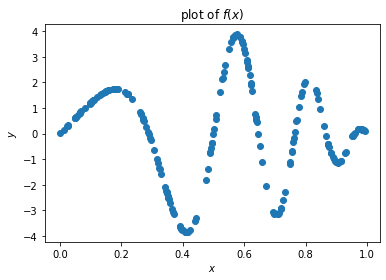

In [256]:
%matplotlib inline

d = 1
n = 200
X = torch.rand(n,d)
y = 4 * torch.sin(np.pi * X) * torch.cos(6*np.pi*X**2)

plt.scatter(X.numpy(), y.numpy())
plt.title('plot of $f(x)$')
plt.xlabel('$x$')
plt.ylabel('$y$')

plt.show()

In [257]:
X.shape

torch.Size([200, 1])

## GD

In [259]:
# feel free to play with these parameters

step_size = 0.05
n_epochs = 6000
n_hidden_1 = 32
n_hidden_2 = 32
d_out = 1

neural_network = nn.Sequential(
    nn.Linear(d, n_hidden_1), 
    nn.Tanh(), # -1~1
    nn.Linear(n_hidden_1, n_hidden_2),
    nn.Tanh(),
    nn.Linear(n_hidden_2, d_out)
)

loss_func = nn.MSELoss()

optim = torch.optim.SGD(neural_network.parameters(), lr=step_size)
print('iter \t loss')
for i in range(n_epochs):
    y_hat = neural_network(X)
    loss = loss_func(y_hat, y)
    optim.zero_grad()
    loss.backward()
    optim.step()
    
    if i % (n_epochs // 10) == 0:
        loss_val = tensor2numpy(loss)
        print('%s \t %.3f'%(i, loss_val))



iter 	 loss
0 	 3.783
600 	 3.674
1200 	 2.058
1800 	 1.424
2400 	 0.760
3000 	 0.545
3600 	 0.411
4200 	 0.330
4800 	 0.251
5400 	 0.200


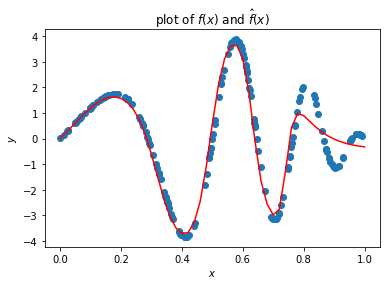

In [275]:
# shape=>size, reshape=>view
X_grid = torch.from_numpy(np.linspace(0,1,51)).float().reshape(-1, d)
y_hat = neural_network(X_grid)
plt.scatter(X.numpy(), y.numpy())
plt.plot(tensor2numpy(X_grid), tensor2numpy(y_hat), 'r')
plt.title('plot of $f(x)$ and $\hat{f}(x)$')
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.show()

In [283]:
print(torch.from_numpy(np.linspace(0,1,3)).float())
print(torch.from_numpy(np.linspace(0,1,3)))

tensor([0.0000, 0.5000, 1.0000])
tensor([0.0000, 0.5000, 1.0000], dtype=torch.float64)


## momentum

In [295]:
# feel free to play with these parameters

step_size = 0.05
momentum = 0.9
n_epochs = 6000
n_hidden_1 = 32
n_hidden_2 = 32
d_out = 1

neural_network = nn.Sequential(
                            nn.Linear(d, n_hidden_1), 
                            nn.Tanh(),
                            nn.Linear(n_hidden_1, n_hidden_2),
                            nn.Tanh(),
                            nn.Linear(n_hidden_2, d_out)
                            )

loss_func = nn.MSELoss()

params = neural_network.parameters()
optim = torch.optim.SGD(params=params, lr=step_size, momentum=momentum)
print('iter \t loss')
for i in range(n_epochs):
    y_hat = neural_network(X)
    loss = loss_func(y_hat, y)
    optim.zero_grad()
    loss.backward()
    optim.step()
    
    if i % (n_epochs // 10) == 0:
        loss_val = tensor2numpy(loss)
        print('%s \t %.3f'%(i, loss_val))



iter 	 loss
0 	 3.866
600 	 0.126
1200 	 0.004
1800 	 0.001
2400 	 0.001
3000 	 0.001
3600 	 0.001
4200 	 0.001
4800 	 0.001
5400 	 0.001


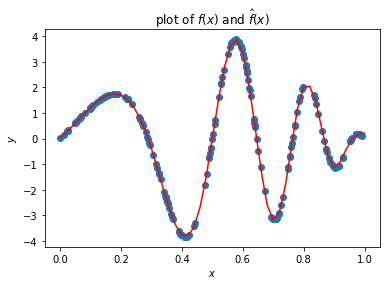

In [286]:
# shape=>size, reshape=>view
X_grid = torch.from_numpy(np.linspace(0,1,51)).float().reshape(-1, d)
y_hat = neural_network(X_grid)
plt.scatter(X.numpy(), y.numpy())
plt.plot(tensor2numpy(X_grid), tensor2numpy(y_hat), 'r')
plt.title('plot of $f(x)$ and $\hat{f}(x)$')
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.show()

In [297]:
import inspect
f=torch.optim.SGD
inspect.signature(f).parameters

mappingproxy({'params': <Parameter "params">,
              'lr': <Parameter "lr=<required parameter>">,
              'momentum': <Parameter "momentum=0">,
              'dampening': <Parameter "dampening=0">,
              'weight_decay': <Parameter "weight_decay=0">,
              'nesterov': <Parameter "nesterov=False">})

# corss entropy

In [314]:
loss = nn.CrossEntropyLoss()

# input = torch.tensor([[-1., 1],[-1, 1],[1, -1]]) # raw scores correspond to the correct class
input = torch.tensor([[-3., 3],[-3, 3],[3, -3]]) # raw scores correspond to the correct class with higher confidence
# input = torch.tensor([[1., -1],[1, -1],[-1, 1]]) # raw scores correspond to the incorrect class
# input = torch.tensor([[3., -3],[3, -3],[-3, 3]]) # raw scores correspond to the incorrect class with incorrectly placed confidence

target = torch.tensor([1, 1, 0])
output = loss(input, target)
print(output)

# input=(3,2), 
# 3=minibatch size, 2=number of classes

# target=(3,)
# 

tensor(0.0025)


In [301]:
f=loss
inspect.signature(f).parameters

mappingproxy({'input': <Parameter "*input">, 'kwargs': <Parameter "**kwargs">})

In [317]:
from scipy.special import softmax
q=softmax([[-3., 3],
           [-3, 3],
           [3, -3]], axis=1)
print(q)
print('#'*50)


# [1,1,0]
p=np.array([[0,1],
            [0,1],
            [1,0]])


L=-p*np.log(q)
print(L)
print('#'*50)

L=np.sum(L,axis=1)
print(L)
print('#'*50)

L=np.mean(L,axis=0)
print(L)

[[0.00247262 0.99752738]
 [0.00247262 0.99752738]
 [0.99752738 0.00247262]]
##################################################
[[-0.          0.00247569]
 [-0.          0.00247569]
 [ 0.00247569 -0.        ]]
##################################################
[0.00247569 0.00247569 0.00247569]
##################################################
0.0024756851377305544


# convoluton

In [320]:
# an entire mnist digit
image = np.array([0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0.3803922 , 0.37647063, 0.3019608 ,0.46274513, 0.2392157 , 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0.3529412 , 0.5411765 , 0.9215687 ,0.9215687 , 0.9215687 , 0.9215687 , 0.9215687 , 0.9215687 ,0.9843138 , 0.9843138 , 0.9725491 , 0.9960785 , 0.9607844 ,0.9215687 , 0.74509805, 0.08235294, 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.54901963,0.9843138 , 0.9960785 , 0.9960785 , 0.9960785 , 0.9960785 ,0.9960785 , 0.9960785 , 0.9960785 , 0.9960785 , 0.9960785 ,0.9960785 , 0.9960785 , 0.9960785 , 0.9960785 , 0.9960785 ,0.7411765 , 0.09019608, 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0.8862746 , 0.9960785 , 0.81568635,0.7803922 , 0.7803922 , 0.7803922 , 0.7803922 , 0.54509807,0.2392157 , 0.2392157 , 0.2392157 , 0.2392157 , 0.2392157 ,0.5019608 , 0.8705883 , 0.9960785 , 0.9960785 , 0.7411765 ,0.08235294, 0., 0., 0., 0.,0., 0., 0., 0., 0.,0.14901961, 0.32156864, 0.0509804 , 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.13333334,0.8352942 , 0.9960785 , 0.9960785 , 0.45098042, 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0.32941177, 0.9960785 ,0.9960785 , 0.9176471 , 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0.32941177, 0.9960785 , 0.9960785 , 0.9176471 ,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0.4156863 , 0.6156863 ,0.9960785 , 0.9960785 , 0.95294124, 0.20000002, 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0.09803922, 0.45882356, 0.8941177 , 0.8941177 ,0.8941177 , 0.9921569 , 0.9960785 , 0.9960785 , 0.9960785 ,0.9960785 , 0.94117653, 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0.26666668, 0.4666667 , 0.86274517,0.9960785 , 0.9960785 , 0.9960785 , 0.9960785 , 0.9960785 ,0.9960785 , 0.9960785 , 0.9960785 , 0.9960785 , 0.5568628 ,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0.14509805, 0.73333335,0.9921569 , 0.9960785 , 0.9960785 , 0.9960785 , 0.8745099 ,0.8078432 , 0.8078432 , 0.29411766, 0.26666668, 0.8431373 ,0.9960785 , 0.9960785 , 0.45882356, 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0.4431373 , 0.8588236 , 0.9960785 , 0.9490197 , 0.89019614,0.45098042, 0.34901962, 0.12156864, 0., 0.,0., 0., 0.7843138 , 0.9960785 , 0.9450981 ,0.16078432, 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0.6627451 , 0.9960785 ,0.6901961 , 0.24313727, 0., 0., 0.,0., 0., 0., 0., 0.18823531,0.9058824 , 0.9960785 , 0.9176471 , 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0.07058824, 0.48627454, 0., 0.,0., 0., 0., 0., 0.,0., 0., 0.32941177, 0.9960785 , 0.9960785 ,0.6509804 , 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0.54509807, 0.9960785 , 0.9333334 , 0.22352943, 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0.8235295 , 0.9803922 , 0.9960785 ,0.65882355, 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0.9490197 , 0.9960785 , 0.93725497, 0.22352943, 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0.34901962, 0.9843138 , 0.9450981 ,0.3372549 , 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.01960784,0.8078432 , 0.96470594, 0.6156863 , 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0.01568628, 0.45882356, 0.27058825,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0.], dtype=np.float32)
image_torch = torch.from_numpy(image).view(1, 1, 28, 28)
# image_torch


In [325]:
f=nn.Conv2d
inspect.signature(f).parameters

mappingproxy({'in_channels': <Parameter "in_channels">,
              'out_channels': <Parameter "out_channels">,
              'kernel_size': <Parameter "kernel_size">,
              'stride': <Parameter "stride=1">,
              'padding': <Parameter "padding=0">,
              'dilation': <Parameter "dilation=1">,
              'groups': <Parameter "groups=1">,
              'bias': <Parameter "bias=True">,
              'padding_mode': <Parameter "padding_mode='zeros'">})

In [326]:
# a gaussian blur kernel
kernel_weight = torch.tensor([[1., 2, 1],[2, 4, 2],[1, 2, 1]]) / 16.0

conv = nn.Conv2d(1, 1, 3)
# manually set the conv weight
conv.weight.data[:] = kernel_weight

conv.weight.data.size()

torch.Size([1, 1, 3, 3])

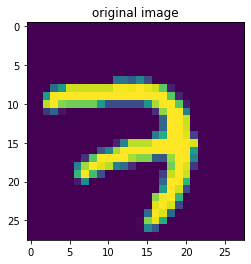

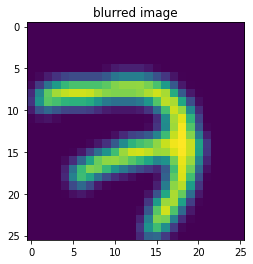

In [327]:
convolved = conv(image_torch)

plt.title('original image')
plt.imshow(image_torch.view(28,28).detach().numpy())
plt.show()

plt.title('blurred image')
plt.imshow(convolved.view(26,26).detach().numpy())
plt.show()

In [329]:
im_channels = 3 # if we are working with RGB images, there are 3 input channels, with black and white, 1
out_channels = 16 # this is a hyperparameter we can tune
kernel_size = 3 # this is another hyperparameter we can tune
batch_size = 4
image_width = 32
image_height = 32

x = torch.randn(batch_size, im_channels, image_width, image_height)

model = nn.Conv2d(im_channels, out_channels, kernel_size)
y = model(x) # it is a module so we can call it

print('im shape', x.shape)
print('convolved im shape', y.shape)


im shape torch.Size([4, 3, 32, 32])
convolved im shape torch.Size([4, 16, 30, 30])


# data loader

In [345]:
from torch.utils.data import Dataset, DataLoader

class FakeDataset(Dataset):

    def __init__(self, X, Y):
        self.X = X
        self.Y = Y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        x = self.X[idx]
        y = self.Y[idx]
        return x, y 

In [346]:
X = np.random.rand(100, 10)
Y = np.random.rand(100)
print(X.shape, Y.shape)

dataset = FakeDataset(X, Y)
dataloader = DataLoader(dataset, batch_size=4, shuffle=True, num_workers=4)

(100, 10) (100,)


In [347]:
for i_batch, data_batch in enumerate(dataloader):
    x_batch = data_batch[0]
    y_batch = data_batch[1]
    print(i_batch, len(data_batch), x_batch.shape, y_batch.shape)

0 2 torch.Size([4, 10]) torch.Size([4])
1 2 torch.Size([4, 10]) torch.Size([4])
2 2 torch.Size([4, 10]) torch.Size([4])
3 2 torch.Size([4, 10]) torch.Size([4])
4 2 torch.Size([4, 10]) torch.Size([4])
5 2 torch.Size([4, 10]) torch.Size([4])
6 2 torch.Size([4, 10]) torch.Size([4])
7 2 torch.Size([4, 10]) torch.Size([4])
8 2 torch.Size([4, 10]) torch.Size([4])
9 2 torch.Size([4, 10]) torch.Size([4])
10 2 torch.Size([4, 10]) torch.Size([4])
11 2 torch.Size([4, 10]) torch.Size([4])
12 2 torch.Size([4, 10]) torch.Size([4])
13 2 torch.Size([4, 10]) torch.Size([4])
14 2 torch.Size([4, 10]) torch.Size([4])
15 2 torch.Size([4, 10]) torch.Size([4])
16 2 torch.Size([4, 10]) torch.Size([4])
17 2 torch.Size([4, 10]) torch.Size([4])
18 2 torch.Size([4, 10]) torch.Size([4])
19 2 torch.Size([4, 10]) torch.Size([4])
20 2 torch.Size([4, 10]) torch.Size([4])
21 2 torch.Size([4, 10]) torch.Size([4])
22 2 torch.Size([4, 10]) torch.Size([4])
23 2 torch.Size([4, 10]) torch.Size([4])
24 2 torch.Size([4, 10]) t